In [2]:
import os
import json
from mistralai.client import MistralClient
from mistralai.models.chat_completion import ChatMessage
from mistralai.models.jobs import TrainingParameters
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score
from sklearn.model_selection import StratifiedKFold

In [3]:
with open("../data/scenario_enhanced_law_cases.json", "r") as f:
    scenarios = json.load(f)

scenarios = [entry for entry in scenarios if isinstance(entry["generated_scenario"], str)]

In [3]:
labels = set([sce["division_type"] for sce in scenarios])
labels

{'Civil', 'Criminal', 'Public'}

In [4]:
PROMPT_CLASSIFIER = """You are an expert lawyer tasked with classifying various cases into three differents category based on the case's description.

The possible categories values are : 'Civil', 'Criminal' or 'Public'. You must select only one of these possible values.

The answer should be a json structured as follow;

{'case_category': predicted category}

For example:

Question:
Case description: "Last week, I was going back home after a hard day of work and a stranger attacked me from behind, hit me one the head and stole my bag"

Answer:
{'case_category': 'Criminal'}
"""

In [48]:
dataset = [
    {
        "messages": [
            {
                "role": "system",
                "content": PROMPT_CLASSIFIER
            },
            {
                "role": "user",
                "content": f"Case description: {scenario['generated_scenario']}"
            },
            {
                "role": "assistant",
                "content": "{'case_category': '[LABEL]'}".replace("[LABEL]", scenario["division_type"])
            },
        ]
    } for scenario in scenarios
]

In [6]:
api_key = os.environ["MISTRAL_API_KEY"]

client = MistralClient(api_key=api_key)
all_preds = {}
for model_name in ["mistral-large-latest", "mistral-small-latest", "open-mistral-7b"]:
    model_preds = []
    for case in dataset[:100]:
        model_preds.append(
            client.chat(
                model=model_name,
                messages=[ChatMessage(role="system", content=PROMPT_CLASSIFIER), ChatMessage(**case["messages"][1])]
            )
        )
    all_preds[model_name] = model_preds


In [198]:
def parse_answer(chat_answer):
    answer = chat_answer.choices[0].message.content
    start_idx = answer.find("{")
    end_idx = answer.find("}")+1
    parsed = eval(answer[start_idx:end_idx])
    if isinstance(parsed["case_category"], str):
        return parsed["case_category"]
    elif isinstance(parsed["case_category"], (list, tuple)):
        return parsed["case_category"][0]
    else:
        return ""


In [140]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
label_mapping = {
    'Civil': 0,
    'Public': 1,
    'Criminal': 2,
}
folds = list(skf.split(dataset, [label_mapping[eval(entry["messages"][-1]["content"])["case_category"]] for entry in dataset]))[0]
train = folds[0]
test = folds[1]

In [155]:
USER_REQUEST = """You are an expert lawyer tasked with classifying various cases into three differents category based on the case description.

Case description: '[CASE]'

The possible categories values are : 'Civil', 'Criminal' or 'Public'. You must select only one of these possible values.

The answer should be a json structured as follow;

{'case_category': predicted category}
"""

In [164]:
finetuning_dataset = [
    {
        "messages": [
            {
                "role": "user",
                "content": USER_REQUEST.replace("[CASE]", case["generated_scenario"]).replace("\"", "\'")
            },
            {
                "role": "assistant",
                "content": "{'case_category': '[LABEL]'}".replace("[LABEL]", case["division_type"])
            }
        ]
    } for case in scenarios
]

In [166]:
test_split = [finetuning_dataset[idx] for idx in test]
train_split = [finetuning_dataset[idx] for idx in train]

In [175]:
with open("training_file.jsonl", "w") as f:
    for item in train_split:
        json.dump(item, f)
        f.write('\n')

In [176]:
# upload the training dataset
with open("training_file.jsonl", "rb") as f:
    training_data = client.files.create(file=("training_file.jsonl", f))    

In [182]:
# create the finetuning job
created_jobs = client.jobs.create(
    model="open-mistral-7b",
    training_files=[training_data.id],
    hyperparameters=TrainingParameters(
        training_steps=10,
        learning_rate=0.0001,
        )
)
created_jobs

Job(id='9f2401ad-f403-4492-b46a-66cacee13ca1', hyperparameters=TrainingParameters(training_steps=10, learning_rate=0.0001), fine_tuned_model=None, model='open-mistral-7b', status='QUEUED', job_type='FT', created_at=1719593037, modified_at=1719593037, training_files=['8bc72522-2910-4427-af06-4ebee54a94ff'], validation_files=[], object='job', integrations=[])

In [184]:
# retrieve the jobs
retrieved_jobs = client.jobs.retrieve(created_jobs.id)
print(retrieved_jobs)

id='9f2401ad-f403-4492-b46a-66cacee13ca1' hyperparameters=TrainingParameters(training_steps=10, learning_rate=0.0001) fine_tuned_model='ft:open-mistral-7b:41dfebed:20240628:9f2401ad' model='open-mistral-7b' status='SUCCESS' job_type='FT' created_at=1719593037 modified_at=1719593133 training_files=['8bc72522-2910-4427-af06-4ebee54a94ff'] validation_files=[] object='job' integrations=[] events=[Event(name='status-updated', data={'status': 'SUCCESS'}, created_at=1719593133), Event(name='status-updated', data={'status': 'RUNNING'}, created_at=1719593039), Event(name='status-updated', data={'status': 'QUEUED'}, created_at=1719593037)] checkpoints=[Checkpoint(metrics=Metric(train_loss=0.059678, valid_loss=None, valid_mean_token_accuracy=None), step_number=10, created_at=1719593109)] estimated_start_time=None


In [188]:
# finetuned model name
retrieved_jobs.fine_tuned_model

'ft:open-mistral-7b:41dfebed:20240628:9f2401ad'

In [213]:
all_preds = {}
for model_name in [retrieved_jobs.fine_tuned_model, "open-mistral-7b"]:
    model_preds = []
    for case in test_split:
        model_preds.append(
            client.chat(
                model=model_name,
                messages=[ChatMessage(**case["messages"][0])]
            )
        )
    all_preds[model_name] = model_preds

In [215]:
truth = [eval(entry["messages"][-1]["content"])["case_category"] for entry in test_split]
preds_finetuned = [parse_answer(answer) for answer in all_preds['ft:open-mistral-7b:41dfebed:20240628:9f2401ad']]
preds_raw = [parse_answer(answer) for answer in all_preds["open-mistral-7b"]]

accuracy 0.7099099099099099


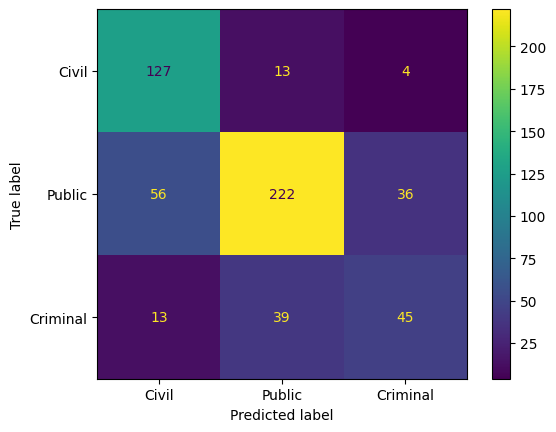

In [217]:
ConfusionMatrixDisplay.from_predictions(
        y_true=truth,
        y_pred=preds_finetuned,
        labels = ["Civil", "Public", "Criminal"]
    )
print("accuracy", accuracy_score(truth, preds_finetuned))

accuracy 0.5459459459459459


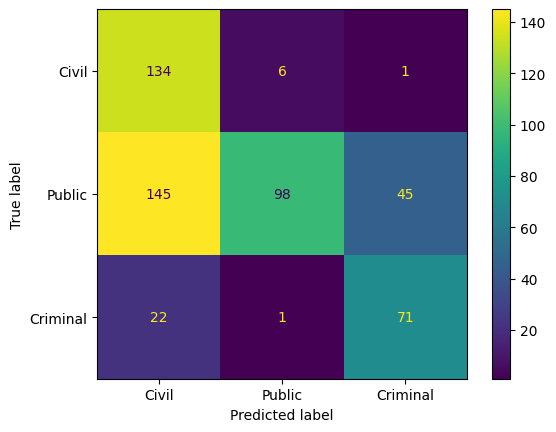

In [218]:
ConfusionMatrixDisplay.from_predictions(
        y_true=truth,
        y_pred=preds_raw,
        labels = ["Civil", "Public", "Criminal"]
    )
print("accuracy", accuracy_score(truth, preds_raw))

In [231]:
with open("finetuned_classif_pred.json", "w") as f:
    for item in all_preds['ft:open-mistral-7b:41dfebed:20240628:9f2401ad']:
        json.dump(item.choices[0].message.content, f)
        f.write('\n')

In [232]:
with open("7b_classif_pred.json", "w") as f:
    for item in all_preds['open-mistral-7b']:
        json.dump(item.choices[0].message.content, f)
        f.write('\n')